In [4]:
!unzip -nq /content/chair_all.zip -d data # terminal command to unzip dataset

In [5]:
import torch
import numpy as np
import time
import torch.optim as optim
from tqdm import tqdm, trange
import utils
import models


In [6]:
cube_len = 32
epoch_count = 400
batch_size = 128
noise_size = 200
d_lr = 0.00005 # discriminator learning rate
g_lr = 0.0025 # generator learning rate
log_folder = "logs/"

condition_count = 2

In [7]:
from torch.utils.data import TensorDataset, DataLoader

all_models1 = utils.load_all("/content/data/chair_all/", contains = '_1.mat') # names ends with a rotation number for 12 rotations, 30 degrees each
all_models7 = utils.load_all("/content/data/chair_all/", contains = '_7.mat') # 1 and 7 are 0 and 180 degrees respectively

train_set1 = torch.from_numpy(all_models1).float()
train_set7 = torch.from_numpy(all_models7).float()

train_set_all = TensorDataset(train_set1, train_set7)
train_loader = DataLoader(dataset=train_set_all, batch_size=batch_size, shuffle=True, pin_memory=True)

In [8]:
device = torch.device("cuda:0")

generator = models.Generator(noise_size=(noise_size + 1), cube_resolution=cube_len) # noise size +1 condition value
discriminator = models.Discriminator(cube_resolution=cube_len)

generator = generator.to(device)
discriminator = discriminator.to(device)

In [9]:
optimizerD = optim.Adam(discriminator.parameters(), lr=d_lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=g_lr, betas=(0.5, 0.999))

In [10]:

class CustomHybridLoss(torch.nn.Module):
    def __init__(self, bce_weight=0.5, l1_weight=0.5):
        super(CustomHybridLoss, self).__init__()
        self.bce_weight = bce_weight
        self.l1_weight = l1_weight
        self.bce_loss = torch.nn.BCELoss()
        self.l1_loss = torch.nn.L1Loss()

    def forward(self, predictions, targets, ):
        bce = self.bce_loss(predictions, targets)
        l1 = self.l1_loss(predictions, targets)
        return self.bce_weight * bce + self.l1_weight * l1

In [11]:
from torch.autograd import Variable
criterion_GAN = torch.nn.BCELoss()
def get_gan_loss(tensor,ones):
    if(ones):
        return criterion_GAN(tensor,Variable(torch.ones_like(tensor.data).to(device), requires_grad=False))
    else:
        return criterion_GAN(tensor,Variable(torch.zeros_like(tensor.data).to(device), requires_grad=False))

In [12]:
def get_noise(b_size = batch_size):
    return torch.randn([b_size,noise_size], device=device)

In [13]:
def train_GAN_epoch():

    g_loss = []
    d_loss = []
    gen_out = []
    train_disc = True

    for i, data_c in enumerate(train_loader):

        acc_list = []

        for c in range(condition_count): # train GAN for each condition

            data = data_c[c].to(device)

            discriminator.zero_grad()
            Dr_output = discriminator(data, c)
            errD_real = get_gan_loss(Dr_output,True)

            fake = generator(get_noise(data.shape[0]), c)
            Df_output = discriminator(fake.detach(), c)
            errD_fake = get_gan_loss(Df_output,False)

            errD = errD_real + errD_fake

            acc_r = Dr_output.mean().item()
            acc_f = 1.0 - Df_output.mean().item()
            acc = (acc_r + acc_f) / 2.0

            acc_list.append(acc) # calculate discriminator accuracy

            if (train_disc): # train discriminator if the last batch accuracy is less than 0.95
                errD.backward()
                optimizerD.step()

            generator.zero_grad() # train generator
            fake = generator(get_noise(), c)
            DGF_output = discriminator(fake, c)
            errG = get_gan_loss(DGF_output,True)
            errG.backward()
            optimizerG.step()

            d_loss.append(errD.mean().item())
            g_loss.append(errG.mean().item())

        generator.zero_grad() # train generator for combined loss
        discriminator.zero_grad()

        fix_noise = get_noise()

        fake0 = generator(fix_noise, 0) # generate for condition 0 and 1
        fake1 = generator(fix_noise, 1)

        fake1_rot = torch.rot90(fake1, 2, [1, 2]) # rotate condition 1
        fake_combined = (fake0 + fake1_rot) / 2.0 # combine them by averaging

        DGF_output_c = discriminator(fake_combined, 0) # train generator for combined output
        errG_c = get_gan_loss(DGF_output_c,True)
        errG_c.backward()
        optimizerG.step()

        train_disc = np.mean(acc_list) < 0.95 # decide for the next batch

    gen_out.append( fake0.detach().cpu() ) # return generated samples for condition 0, 1 and combined
    gen_out.append( fake1.detach().cpu() )
    gen_out.append( fake_combined.detach().cpu() )

    return np.mean(d_loss), np.mean(g_loss) , gen_out

In [14]:
utils.clear_folder(log_folder) # create log folder
log_file = open(log_folder +"logs.txt" ,"a") # open log file

In [15]:
d_list = []
g_list = []

pbar = tqdm( range(epoch_count+1) )
for i in pbar :

    startTime = time.time()

    d_loss, g_loss, gen = train_GAN_epoch() #train GAN for 1 epoch

    d_list.append(d_loss) # get discriminator and generator loss
    g_list.append(g_loss)

    utils.plot_graph([d_list,g_list], log_folder + "loss_graph") # plot loss graph up to that epoch

    epoch_time = time.time() - startTime

    writeString = "epoch %d --> d_loss:%0.3f g_loss:%0.3f time:%0.3f" % (i, d_loss, g_loss, epoch_time) # generate log string

    pbar.set_description(writeString)
    log_file.write(writeString + "\n") # write to log file
    log_file.flush()

    if(i%10 == 0): # save generated samples for each 10th epoch because it takes a long time to visualize the samples
        utils.visualize_all(gen, save=True, name = log_folder + "samples_epoch" + str(i))

epoch 400 --> d_loss:0.253 g_loss:2.907 time:7.371: 100%|██████████| 401/401 [1:29:02<00:00, 13.32s/it]


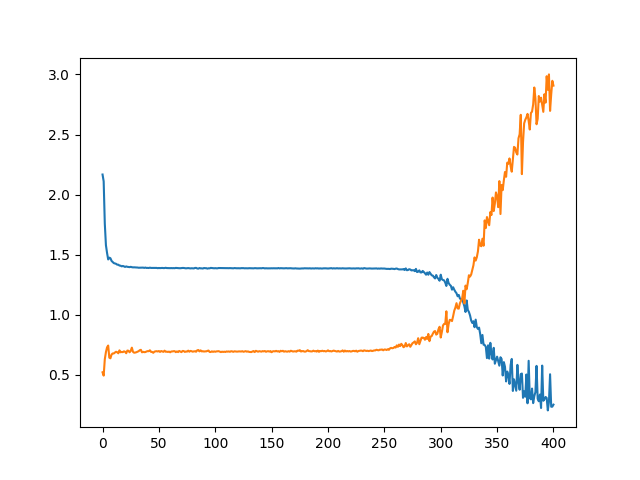

In [16]:
from PIL import Image

# Open the image
img = Image.open('/content/logs/loss_graph.png')

# Display the image
img

In [17]:
from PIL import Image

# Open the image
img = Image.open('/content/logs/samples_epoch400.png')

# Display the image
img.show()

In [18]:
file_path = '/content/logs/logs.txt'

try:
    with open(file_path, 'r') as file:
        file_lines = file.readlines()
        print("File Content:")
        for line in file_lines:
            print(line.strip())
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")


File Content:
epoch 0 --> d_loss:2.168 g_loss:0.521 time:8.486
epoch 1 --> d_loss:2.111 g_loss:0.494 time:7.279
epoch 2 --> d_loss:1.759 g_loss:0.630 time:7.241
epoch 3 --> d_loss:1.579 g_loss:0.690 time:7.286
epoch 4 --> d_loss:1.515 g_loss:0.729 time:7.458
epoch 5 --> d_loss:1.461 g_loss:0.744 time:7.397
epoch 6 --> d_loss:1.476 g_loss:0.644 time:7.494
epoch 7 --> d_loss:1.471 g_loss:0.638 time:7.497
epoch 8 --> d_loss:1.449 g_loss:0.670 time:7.478
epoch 9 --> d_loss:1.439 g_loss:0.679 time:7.473
epoch 10 --> d_loss:1.430 g_loss:0.678 time:7.352
epoch 11 --> d_loss:1.427 g_loss:0.686 time:7.173
epoch 12 --> d_loss:1.424 g_loss:0.693 time:7.137
epoch 13 --> d_loss:1.417 g_loss:0.688 time:7.174
epoch 14 --> d_loss:1.417 g_loss:0.680 time:7.265
epoch 15 --> d_loss:1.410 g_loss:0.704 time:7.248
epoch 16 --> d_loss:1.409 g_loss:0.688 time:7.269
epoch 17 --> d_loss:1.403 g_loss:0.691 time:7.282
epoch 18 --> d_loss:1.407 g_loss:0.689 time:7.333
epoch 19 --> d_loss:1.403 g_loss:0.696 time:7.